In [1]:
#Making necesarry imports
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')
import os, sys
import re
import seaborn as sns
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [2]:
#Setting the current working directory
os.chdir('C:\\Users\\cliff\\Desktop\\PyShark project')
os.getcwd()

'C:\\Users\\cliff\\Desktop\\PyShark project'

In [3]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [4]:
train = pd.read_csv('train_review.csv')
train.head()

,user_id,business_id,stars
0,YHWsLBS8jzZiPjKHMFOaAA,gl1zQmiA8MUHmLL2wsCdVA,3
1,YHWsLBS8jzZiPjKHMFOaAA,OR6iRk0vrMzE-1gLg-WYrw,2
2,YHWsLBS8jzZiPjKHMFOaAA,qAg8GkN9rforFWmGxBqVqA,3
3,YHWsLBS8jzZiPjKHMFOaAA,VhQXJteVrG3L-wq8HlYFqw,4
4,YHWsLBS8jzZiPjKHMFOaAA,CN5nuUQod0f8g3oh99qq0w,4


In [5]:
train.dtypes


user_id        object
business_id    object
stars           int64
dtype: object

In [6]:
test = pd.read_csv('test_review.csv')
test.head(10)

,user_id,business_id,stars
0,YHWsLBS8jzZiPjKHMFOaAA,iKMLsX1Je7P3wAOEc9scDg,4
1,YHWsLBS8jzZiPjKHMFOaAA,amsvLzfEvCzLwP0MnXAJ1w,4
2,YHWsLBS8jzZiPjKHMFOaAA,43PeF0ERpSIiEbXM6f9N2g,3
3,YHWsLBS8jzZiPjKHMFOaAA,y-sRypoTK2L6EuozhEMQzA,2
4,YHWsLBS8jzZiPjKHMFOaAA,VeVjZ8aR_zFEM9jKJuvraw,4
5,YgavGxfAdjhkkbwlAY_9ZQ,dgpPVSFL84ONx477Lln2sw,4
6,YgavGxfAdjhkkbwlAY_9ZQ,edf1UxWW9-7u_f35kbvEwQ,3
7,q3AiAe-AcpDrNsdZf8nCvQ,YmFkrylzWy4vmNFkWk-I0g,5
8,q3AiAe-AcpDrNsdZf8nCvQ,whAwdYVty-jSNRhrYT2zHA,5
9,q3AiAe-AcpDrNsdZf8nCvQ,7XTGtaKjANmZqp2QtN_iPA,4


In [8]:
test_df = test[["user_id","business_id"]]
test_df.head()

,user_id,business_id
0,YHWsLBS8jzZiPjKHMFOaAA,iKMLsX1Je7P3wAOEc9scDg
1,YHWsLBS8jzZiPjKHMFOaAA,amsvLzfEvCzLwP0MnXAJ1w
2,YHWsLBS8jzZiPjKHMFOaAA,43PeF0ERpSIiEbXM6f9N2g
3,YHWsLBS8jzZiPjKHMFOaAA,y-sRypoTK2L6EuozhEMQzA
4,YHWsLBS8jzZiPjKHMFOaAA,VeVjZ8aR_zFEM9jKJuvraw


In [9]:
#making this setting to display full text in columns
pd.set_option('display.max_colwidth', -1)

In [10]:
print(train['user_id'].unique())
#Now it can be seen that yearOfPublication has all values as integers

['YHWsLBS8jzZiPjKHMFOaAA' 'YgavGxfAdjhkkbwlAY_9ZQ'
 'q3AiAe-AcpDrNsdZf8nCvQ' ... 'wskTNZjwiqMJOvM_-XAQZw'
 '2bkjcc1N8jneRsPs_dz0kw' 'Rdtp3Yam3moqnGIG3td3wA']


In [11]:
#exploring for NA's
na_s=train['user_id'].isnull()
na_s.describe()
na_s=train['stars'].isnull()
na_s.describe()
na_s=train['business_id'].isnull()
na_s.describe()

count     407117
unique    1     
top       False 
freq      407117
Name: business_id, dtype: object

**Ratings Dataset**

In [12]:
#ratings dataset will have n_users*n_business entries if every user rated every item,
#this shows that the dataset is very sparse
n_users = train['user_id'].unique().shape[0]
n_business= train['business_id'].unique().shape[0]
print( n_users * n_business)

801870504


In [13]:
train['user_id'].unique().shape[0]

28216

In [14]:
#checking first few rows...
ratings=train[['business_id','stars']]
ratings.head()

,business_id,stars
0,gl1zQmiA8MUHmLL2wsCdVA,3
1,OR6iRk0vrMzE-1gLg-WYrw,2
2,qAg8GkN9rforFWmGxBqVqA,3
3,VhQXJteVrG3L-wq8HlYFqw,4
4,CN5nuUQod0f8g3oh99qq0w,4


In [15]:
ratings['business_id'].unique().shape[0]

28419

In [16]:
print( "number of users: " + str(n_users))
print ("number of businesses: " + str(n_business))

number of users: 28216
number of businesses: 28419


In [17]:
ratings_new=train

In [18]:
#Sparsity of dataset in %
sparsity=1.0-len(ratings_new['stars'])/float(n_users*n_business)
print ('The sparsity level of Book Crossing dataset is ' +  str(sparsity*100) + ' %')

The sparsity level of Book Crossing dataset is 99.94922908400183 %


In [19]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings['stars'] != 0]
ratings_implicit = ratings_new[ratings['stars'] == 0]

In [20]:
#checking shapes
print (ratings.shape)
print (ratings_explicit.shape)
print (ratings_implicit.shape)

(407117, 2)
(407117, 3)
(0, 3)


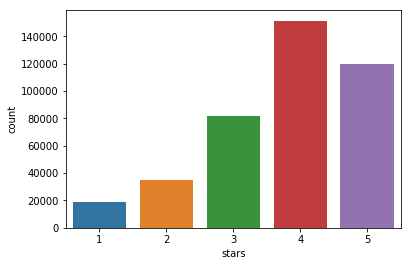

In [21]:
#plotting count of stars
sns.countplot(data=ratings_explicit , x='stars')
plt.show()
#It can be seen that higher ratings are more common amongst users and rating 8 has been rated highest number of times

**Collaborative Filtering Based Recommendation Systems**

In [22]:
#To cope up with computing power I have and to reduce the dataset size, 
counts1 = ratings_explicit['user_id'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['user_id'].isin(counts1[counts1 >= 6].index)]
counts = ratings_explicit['stars'].value_counts()

In [23]:
#Generating ratings matrix from explicit ratings table
ratings_matrix = ratings_explicit.pivot(index='user_id', columns='business_id', values='stars')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()
#Notice that most of the values are NaN (undefined) implying absence of ratings

(11845, 28290)


business_id,--7zmmkVg-IMGaXbuVd0SQ,--9e1ONYQuAa-CB_Rrw7Tw,--DaPTJW3-tB1vP-PfdTEg,--FBCX-N37CMYDfs790Bnw,--I7YYLada0tSLkORTHb5Q,--SrzpvFLwP_YFwB_Cetow,--cZ6Hhc9F7VkKXxHMVZSQ,--cjBEbXMI2obtaRHNSFrA,--ujyvoQlwVoBgMYtADiLA,-01XupAWZEXbdNbxNg5mEg,...,zyw5DjrRks7a8OhmBsgCQQ,zz3CqZhNx2rQ_Yp6zHze-A,zzSYBWuv_fXGtSgsO-6_1g,zzUj3ej4vm_DtvRxNvWDEw,zzlZJVkEhOzR2tJOLHcF2A,zzmIMvqiBJ_-wVKg_OnGpw,zzsOLFhgUw8gnjLTVVItFA,zzwaS0xn1MVEPEf0hNLjew,zzwhN7x37nyjP0ZM8oiHmw,zzwicjPC9g246MK2M1ZFBA
user_id,,,,,,,,,,,,,,,,,,,,,
--CIuK7sUpaNzalLAlHJKA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ZNfWKj1VyVElRx6-g1fg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ty7Z9fEt08E3dS3_qoSA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0AyZxS5C--WySnbW_Q8yQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0D44Oa5eolEFmaIM4MbWA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
n_users = ratings_matrix.shape[0] #considering only those users who gave explicit ratings
n_books = ratings_matrix.shape[1]
print (n_users, n_business)

15808 28419


In [ ]:
#since NaNs cannot be handled by training algorithms, replacing these by 0, which indicates absence of ratings
#setting data type
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [239]:
#checking first few rows
ratings_matrix.head(5)

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [240]:
#rechecking the sparsity
sparsity=1.0-len(ratings_explicit)/float(users_exp_ratings.shape[0]*n_books)
print 'The sparsity level of Book Crossing dataset is ' +  str(sparsity*100) + ' %'

The sparsity level of Book Crossing dataset is 99.9977218411 %


**Training our recommendation system**

In [241]:
#setting global variables
global metric,k
k=10
metric='cosine'

**User-based Recommendation System**

In [242]:
#This function finds k similar users given the user_id and ratings matrix 
#These similarities are same as obtained via using pairwise_distances
def findksimilarusers(user_id, ratings_matrix, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
            
    return similarities,indices

In [243]:
#This function predicts rating for specified user-item combination based on user-based approach
def predict_userbased(user_id, item_id, ratings_matrix, metric = metric, k=k):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings_matrix,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_loc,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print '\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction)

    return prediction

In [244]:
predict_userbased(test_df,ratings_matrix);


Predicted rating for user 11676 -> item 0001056107: 2


In [ ]:
#This is final function to evaluate the performance of selected recommendation approach and the metric used here is RMSE
#suppress_stdout function is used to suppress the print outputs of all the functions inside this function. It will only print 
#RMSE values
def evaluateRS(ratings):
    ids = ['User-based CF (cosine)','User-based CF (correlation)','Item-based CF (cosine)','Item-based CF (adjusted cosine)']
    approach = widgets.Dropdown(options=ids, value=ids[0],description='Select Approach', width='500px')
    n_users = ratings.shape[0]
    n_items = ratings.shape[1]
    prediction = np.zeros((n_users, n_items))
    prediction= pd.DataFrame(prediction)
    def on_change(change):
        clear_output(wait=True)
        with suppress_stdout():
            if change['type'] == 'change' and change['name'] == 'value':            
                if (approach.value == 'User-based CF (cosine)'):
                    metric = 'cosine'
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(i+1, j+1, ratings, metric)
                elif (approach.value == 'User-based CF (correlation)')  :                       
                    metric = 'correlation'               
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(i+1, j+1, ratings, metric)
                elif (approach.value == 'Item-based CF (cosine)'):
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(i+1, j+1, ratings)
                else:
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(i+1, j+1, ratings)
              
        MSE = mean_squared_error(prediction, ratings)
        RMSE = round(sqrt(MSE),3)
        print "RMSE using {0} approach is: {1}".format(approach.value,RMSE)
              
    approach.observe(on_change)
    display(approach)

In [ ]:
evaluateRS(M)

**Thanks for reading this notebook**